In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Downloading target Datasets form OpenDatasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Downloading test Data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



#### Now that ww have the datasets lets load them up in variables

In [3]:
batch_size = 64

#creating Data Loaders
train_dataloader = DataLoader(training_data,batch_size)
test_dataloader = DataLoader(test_data,batch_size)

In [8]:
import matplotlib.pyplot as plt

### Iterating and Visualizing Datasets

In [11]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [28]:
training_data[0][0].shape

torch.Size([1, 28, 28])

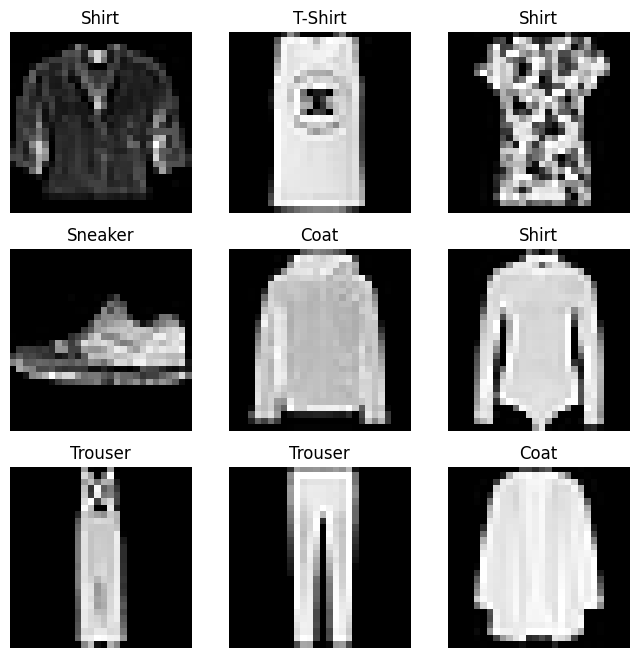

In [31]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3

for i in range(1, cols * rows+1):
    sample_index = torch.randint(len(training_data),size=(1,)).item()
    img, label = training_data[sample_index]
    figure.add_subplot(rows,cols, i)
    plt.title(label=labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()


In [32]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating Models

In [33]:
# Get GPU or CPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}") 

Using cpu


#### Defining Model

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [35]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Optimizing the Model parameters

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

In [37]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute Prediction
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss : {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [38]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [39]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss : 2.294620  [    0/60000]
loss : 2.278802  [ 6400/60000]
loss : 2.263374  [12800/60000]
loss : 2.262915  [19200/60000]
loss : 2.245114  [25600/60000]
loss : 2.207227  [32000/60000]
loss : 2.222017  [38400/60000]
loss : 2.172615  [44800/60000]
loss : 2.181314  [51200/60000]
loss : 2.151423  [57600/60000]
Test Error: 
 Accuracy: 46.5%, Avg loss: 2.140736 

Epoch 2
-------------------------------
loss : 2.147872  [    0/60000]
loss : 2.129809  [ 6400/60000]
loss : 2.078588  [12800/60000]
loss : 2.103370  [19200/60000]
loss : 2.043621  [25600/60000]
loss : 1.976575  [32000/60000]
loss : 2.010952  [38400/60000]
loss : 1.917992  [44800/60000]
loss : 1.934927  [51200/60000]
loss : 1.864268  [57600/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 1.856009 

Epoch 3
-------------------------------
loss : 1.889539  [    0/60000]
loss : 1.846562  [ 6400/60000]
loss : 1.739465  [12800/60000]
loss : 1.789985  [19200/60000]
loss : 1.674506  [25600/60000]
l

### Saving the model parameters by serializing the internal state dict

In [40]:
torch.save(model.state_dict(), "outputs/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Loading the Saved Model

In [42]:
model = NeuralNetwork()
model.load_state_dict(torch.load("outputs/model.pth"))

<All keys matched successfully>

#### Kaing predictions

In [43]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
